In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## 图像矢量风格化

In [9]:
img = cv2.imread('./tree.jpg')
yuv = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2YUV) # 转换为yuv颜色空间

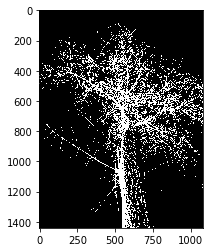

In [11]:
edges = cv2.inRange(yuv[:,:,0],0.017,105.5)
plt.imshow(edges,'gray')

In [ ]:
cv2.Cal